# Multi-Head Attention


In practice, given the same set of queries, keys, and values we may want our model to combine knowledge from
different behaviors of the same attention mechanism,
such as capturing dependencies of various ranges
(e.g., shorter-range vs. longer-range) within a sequence.
Thus, it may be beneficial to allow our attention mechanism to jointly use different representation subspaces of queries, keys, and values.


To this end, instead of performing 
a single attention pooling,
queries, keys, and values
can be transformed
with $h$ independently learned linear projections.
Then these $h$ projected queries, keys, and values
are fed into attention pooling in parallel.
In the end,
$h$ attention-pooling outputs
are concatenated and 
transformed with another learned linear projection
to produce the final output.
This design
is called *multi-head attention*,
where each of the $h$ attention pooling outputs
is a *head* :cite:`Vaswani.Shazeer.Parmar.ea.2017`.
Using fully connected layers
to perform learnable linear transformations,
:numref:`fig_multi-head-attention`
describes multi-head attention.

![Multi-head attention, where multiple heads are concatenated then linearly transformed.](../img/multi-head-attention.svg)
:label:`fig_multi-head-attention`


In [4]:
using Pkg; Pkg.activate("../../d2lai")
using LinearAlgebra
using d2lai
using Flux 
using Downloads
using StatsBase
using Plots
using d2lai: DotProductAttention, Seq2Seq, AbstractEncoderDecoder, Seq2SeqEncoder, AdditiveAttention, StackedRNN, Seq2SeqAttentionDecoder

  Activating project at `/workspace/workspace/d2l-julia/d2lai`


## Model

Before providing the implementation of multi-head attention,
let's formalize this model mathematically.
Given a query $\mathbf{q} \in \mathbb{R}^{d_q}$,
a key $\mathbf{k} \in \mathbb{R}^{d_k}$,
and a value $\mathbf{v} \in \mathbb{R}^{d_v}$,
each attention head $\mathbf{h}_i$  ($i = 1, \ldots, h$)
is computed as

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

where 
$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$,
and $\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$
are learnable parameters and
$f$ is attention pooling,
such as
additive attention and scaled dot product attention
in :numref:`sec_attention-scoring-functions`.
The multi-head attention output
is another linear transformation via 
learnable parameters
$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$
of the concatenation of $h$ heads:

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

Based on this design, each head may attend
to different parts of the input.
More sophisticated functions 
than the simple weighted average can be expressed.

## Implementation

In our implementation,
we choose the scaled dot product attention
for each head of the multi-head attention.
To avoid significant growth of computational cost and parametrization cost,
we set $p_q = p_k = p_v = p_o / h$.
Note that $h$ heads can be computed in parallel
if we set the number of outputs 
of linear transformations
for the query, key, and value
to $p_q h = p_k h = p_v h = p_o$.
In the following implementation,
$p_o$ is specified via the argument `num_hiddens`.

In [5]:
struct MultiHeadedAttention{W, AT, A} <: AbstractModel
    weights::W 
    attention::AT
    args::A
end

Flux.@layer MultiHeadedAttention trainable = (weights, )
function MultiHeadedAttention(num_hiddens::Int64, num_heads::Int64, dropout::AbstractFloat; bias=false)
    W_q = Dense(num_hiddens, num_hiddens, bias = bias)
    W_k = Dense(num_hiddens, num_hiddens, bias = bias)
    W_v = Dense(num_hiddens, num_hiddens, bias = bias)
    W_o = Dense(num_hiddens, num_hiddens, bias = bias)
    attn = DotProductAttention(Dropout(dropout), (;))
    MultiHeadedAttention((; W_q, W_k, W_v, W_o), attn, (; num_hiddens, num_heads, dropout))
end

function (m::MultiHeadedAttention)(queries, keys, values, valid_lens)
    # queries -> q_d x num_queries x batch_size 
    # keys -> k_d x num_key_val x batch_size 
    # values -> v_d x num_key_val x batch_size
    queries = m.weights.W_q(queries) # num_hiddens x num_queries x batch_size
    queries = transpose_qkv(m, queries) # (num_hiddens / num_heads) x num_queries x (num_heads * batch_size)
    keys = transpose_qkv(m, m.weights.W_k(keys)) # (num_hiddens / num_heads) x num_key_val x (num_heads * batch_size)
    values = transpose_qkv(m, m.weights.W_v(values))# (num_hiddens / num_heads) x num_key_val x (num_heads * batch_size)
    valid_lens = if !isnothing(valid_lens)
        isa(valid_lens, AbstractVector) ? repeat(valid_lens, inner = m.args.num_heads) : repeat(valid_lens, inner = (m.args.num_heads, 1))
        
    end
    scores, attn_wts = m.attention(queries, keys, values, valid_lens) # (num_hiddens / num_heads) x num_queries x (num_heads * batch_size) 
    # attn_wts -> num_key_val x num_queries x batch_size
    output_concat = transpose_output(m, scores) # num_hiddens x num_queries x batch_size
    return m.weights.W_o(output_concat), attn_wts # 
end

function transpose_qkv(m::MultiHeadedAttention, x)
    # x -> num_hiddens x (num_queries or num_key_val) x batch_size 
    num_q_or_key_val = size(x, 2)
    batch_size = size(x, 3)
    x_ = reshape(x, :, m.args.num_heads, num_q_or_key_val, batch_size)
    x_permuted = permutedims(x_, [1, 3, 2, 4]) # (num_hiddens / num_heads) x num_queries x num_heads x batch_size
    return reshape(x_permuted, size(x_permuted)[1], size(x_permuted)[2], :) # (num_hiddens / num_heads) x num_queries x (num_heads * batch_size)
end

function transpose_output(m::MultiHeadedAttention, x)
    x_ = reshape(x, size(x)[1], size(x)[2], m.args.num_heads, :)
    x_permuted = permutedims(x_, [1, 3, 2, 4])
    return reshape(x, :, size(x_permuted)[3], size(x_permuted)[4]) 
end


transpose_output (generic function with 1 method)

In [6]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadedAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = [3, 2]
X = ones((num_hiddens, num_queries, batch_size))
Y = ones((num_hiddens, num_kvpairs, batch_size))

context, attn_wt = attention(X, Y, Y, valid_lens)
@assert size(context) == (num_hiddens, num_queries, batch_size)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(100 => 100; bias=false)  # 10_000 parameters
│   summary(x) = "100×8 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/3711C/src/layers/stateless.jl:60


Internal error: during type inference of
_pullback_generator(UInt64, LineNumberNode, Type, Type, Type, NTuple{1026, DataType})
Encountered stack overflow.
This might be caused by recursion over very long tuples or argument lists.
Internal error: during type inference of
_pullback(Zygote.Context{false}, typeof(Core.kwcall), NamedTuple{(:dims,), Tuple{Int64}}, typeof(Base.cat), Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2}, Array{Bool, 2

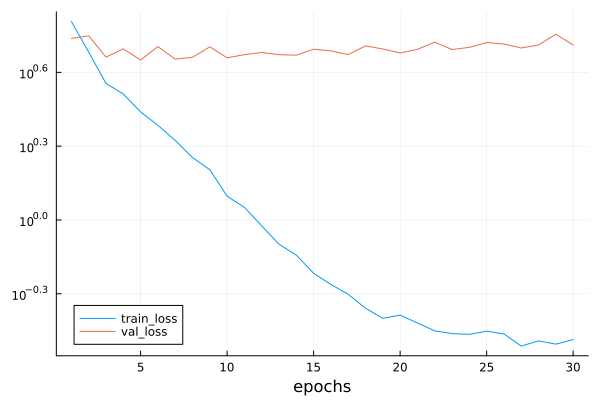

In [7]:
function Seq2SeqMultiAttentionDecoder(vocab_size::Int, embed_size::Int, num_hiddens, num_layers, num_heads, dropout=0.)
    embedding = Embedding(vocab_size => embed_size)
    rnn = StackedRNN(embed_size + num_hiddens, num_hiddens, num_layers; rnn = Flux.LSTM)
    attention = MultiHeadedAttention(num_hiddens, num_heads, dropout)
    dense = Dense(num_hiddens, vocab_size) 
    args = (; vocab_size, embed_size, num_hiddens, num_layers)
    Seq2SeqAttentionDecoder(attention, embedding, rnn, dense, args)
end




data = d2lai.MTFraEng(128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
num_heads = 8

encoder = Seq2SeqEncoder(length(data.src_vocab), embed_size, num_hiddens, num_layers)
decoder = Seq2SeqMultiAttentionDecoder(length(data.tgt_vocab), embed_size, num_hiddens, 1, num_heads)
model = Seq2Seq(encoder, decoder, data.tgt_vocab["<pad>"])

opt = Flux.Adam(0.01)
trainer = Trainer(model, data, opt; max_epochs = 30, gpu = true, gradient_clip_val = 1.)
m, _ = d2lai.fit(trainer);

In [8]:
engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]


batch = d2lai.build(data, engs, fras)
preds, _ = d2lai.predict_step(m, batch, cpu, data.args.num_steps; save_attention_wts = true)

for (en, fr, p) in zip(engs, fras, eachcol(preds))
    translation = []
    for token in d2lai.to_tokens(data.tgt_vocab, p)
        if token == "<eos>"
            break
        end
        push!(translation, token)
    end 
    bleu_score = d2lai.bleu(join(translation, " "), fr, 2)
    println("$en => $translation", "bleu: $bleu_score")
end

go . => Any["va", "!"]bleu: 1.0
i lost . => Any["j'ai", "perdu", "."]bleu: 1.0
he's calm . => Any["j'en", "fais", "."]bleu: 0.0
i'm home . => Any["je", "suis", "chez", "moi", "."]bleu: 1.0


In [13]:
btch = d2lai.build(data, [engs[end]], [fras[end]])
_, dec_attention_weights = d2lai.predict_step(m, btch, cpu, data.args.num_steps; save_attention_wts = true);

In [14]:
attention_weights = cat([step[1] for step in dec_attention_weights]..., dims = 3)
attention_weights = reshape(attention_weights, :, data.args.num_steps, 1, 1)

72×9×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0197803   0.50357      0.88467      …  0.673018   0.602622   0.658632
 0.294253    0.111737     0.0296061       0.110218   0.128447   0.102955
 0.501421    0.138298     0.029734        0.0741955  0.106384   0.0875043
 0.184546    0.246395     0.05599         0.142569   0.162548   0.150908
 0.0         0.0          0.0             0.0        0.0        0.0
 0.0         0.0          0.0          …  0.0        0.0        0.0
 0.0         0.0          0.0             0.0        0.0        0.0
 0.0         0.0          0.0             0.0        0.0        0.0
 0.0         0.0          0.0             0.0        0.0        0.0
 0.867143    0.000183062  0.863314        0.167611   0.0753995  0.0480836
 0.12625     0.00259461   0.0396935    …  0.161772   0.107583   0.0798361
 0.00453269  0.241328     0.0382949       0.318684   0.337655   0.345838
 0.00207432  0.755895     0.0586977       0.351933   0.479362   0.526242
 ⋮                            